# Assignment - 2: Data Representation and Point Cloud Operations

Team Name: Whatevs

Roll number: 2019101017, 2019101049

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- The **References** section provides you with important resources to solve the assignment.
- Make sure your code is modular since you may need to reuse parts for future assignments.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- The **deadline** for this assignment is on 26/09/2021 at 11:55pm. Please note that there will be no extensions.
- Plagiarism is **strictly prohibited**.

# Submission Instructions

1. Make sure your code runs without any errors after reinitializing the kernel and removing all saved variables.
2. After completing your code and saving your results, zip the folder with name as ``Team_<team_name>_MR2021_Assignment_<assignment_number>.zip``

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import os
import copy

# Introduction to types of Transformations and Homogeneous coordinates

In robotics applications, it is inevitable to keep track of the frames of multiple objects/worlds. These frames can be transformations from one coordinate frame to the other. **Homogeneous coordinates** help in keeping track of various coordinate frames and allow performing composition of various transforms. We will first try to understand between types of transformations and their invariant properties.
1. What is the difference between Affine, Similarity, and Euclidean transform? What are the invariant properities of each type of transform?
2. Watch this [video](https://www.youtube.com/watch?v=PvEl63t-opM) to briefly understand homogeneous coordinates. What are points at infinity? What type of transformation can you apply to transform a point from infinity to a point that is not at infinity? 
3. Using homogeneous coordinates we can represent different types of transformation as point transforms vs. frame transforms. Concatenation of transforms (whether you post multiply transformation matrices or pre-multiply transformation matrices) depends on the problem and how you are viewing it. Try to understand the difference between frame vs. point transformations from this [video](https://youtu.be/Za7Sdegf8m8?t=1834). Let's assume that our camera and world frames are coinciding with each other. We need to estimate the camera to world **frame** transformation matrix after applying the transformations defined below in terms of $T_i$.We apply **frame** transform to move the camera in the world in the following order:
    1. $T_1$ from the camera coordinate frame.
    2. $T_2$ from the world coordinate frame.
    3. $T_3$ from the world coordinate frame.
    4. $T_4$ from the camera coordinate frame.
    5. $T_5$ from the camera coordinate frame.


1. Euclidean transforms include translation, rotation and reflection and only bring about changes in the position and orientation of objects. They generally have 6 parameters (3 rotation + 3 translation). <br />
Similarity transforms, in addition to the euclidean transforms, include a scaling factor, thus affecting the length of lines and objects. They generally have 7 parameters (3 rotation + 3 translation + 1 scaling). <br />
Affine transforms, in addition to the euclidean transforms, include scaling and shear factors for each axis, thus affecting the length and angles in objects. They generally have 12 parameters (3 rotation + 3 translation + 3 scaling + 3 shear). <br />
Euclidean transforms are length and angle preserving, similarity transforms are angle preserving and shape preserving but not length preserving and affine transforms don't preserve both lengths and angles but lines remain lines (collinearity is preserved), parallelism is preserved, i.e, parallel lines remain parallel, and points at infinity are mapped to points at infinity.

2. Points at infinity can be easily represented in homogeneous coordinates while retaining the direction information. Points with a scaling factor (last coordinate) of 0 represent points at infinity as when we convert to euclidean coordinates, the division of the other coordinates by the scaling factor yields infinity. We can apply a projective transformation to a point at infinity to make it a finite point.

3. (T<sub>3</sub> * T<sub>2</sub> * T<sub>i</sub> * T<sub>1</sub> * T<sub>4</sub> * T<sub>5</sub>)<sup>-1</sup> = 
T<sub>5</sub><sup>-1</sup> * T<sub>4</sub><sup>-1</sup> * T<sub>1</sub><sup>-1</sup> * T<sub>i</sub><sup>-1</sup> * T<sub>2</sub><sup>-1</sup> * T<sub>3</sub><sup>-1</sup>

#### Homogeneous coordinates
- Homogneous coordinates are obtained from Euclidean coordinates by including an extra dimension (=1) known as the scaling factor.
- Homogeneous coordinates have 2 main advantages:
    - They allow us to represent various transforms as matrices (ex: translation and scaling). This makes it easy to apply transforms to a point (matrix-vector multiplication) and chain multiple transforms (matrix-matrix multiplication).
    - They allow us to represent points at infinity while maintaining direction information about the point. Points with a scaling factor (last coordinate) of 0 represent points at infinity, as when we convert to euclidean coordinates, the division of the other coordinates by the scaling factor yields infinity. We can apply a projective transformation to a point at infinity to make it a finite point.
    
#### Types of transforms
- Euclidean transforms include translation, rotation and reflection and only bring about changes in the position and orientation of objects. They generally have 6 parameters (3 rotation + 3 translation).
- Similarity transforms, in addition to the euclidean transforms, include a scaling factor to uniformly scale each axis. They affect the length of lines and objects. They generally have 7 parameters (3 rotation + 3 translation + 1 scaling).
- Affine transforms, in addition to the euclidean transforms, include scaling and shear factors for each axis, thus affecting the length and angles in objects. They generally have 12 parameters (3 rotation + 3 translation + 3 scaling + 3 shear).
- Euclidean transforms are length and angle preserving. Similarity transforms are not length preserving but are angle and shape preserving. Affine transforms are neither angle nor line preserving. They are collinearity preserving (lines remain lines) and parallelism preserving (parallel lines remain parallel, and points at infinity are mapped to points at infinity).

#### Point and frame transforms

- Point transformation matrix and frame transformation matrix are inverse of each other.
- When multiplying frame transforms:
    - Transforms in camera frame are post-multiplied (on the right)
    - Transforms in world frame are pre-multiplied (on the left)
    - This gives us world to camera FRAME transformation.

- World -> Camera FRAME transform == Camera -> World POINT transform  
- World -> Camera POINT transform == Camera -> World FRAME transform

# Visualise the Data

Point clouds are a collection of points that represent a 3D shape or feature. Each point has its own set of X, Y and Z coordinates and in some cases additional attributes. A popular way to obtain this is by photogrammetry, though here we will use LiDAR data.

LiDAR is a remote sensing process which collects measurements used to create 3D models and maps of objects and environments. Using ultraviolet, visible, or near-infrared light, LiDAR gauges spatial relationships and shapes by measuring the time it takes for signals to bounce off objects and return to the scanner.

1. Download the data from [here](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/venkata_surya_students_iiit_ac_in/EnYAMaTVIhJItzKYqtahE30BRKB6p6UfHN3TyJzvo6Mw0g?e=PegWds). It contains the LIDAR sensor output and odometry information per frame.

    The .bin files contain the 3D point cloud captured by the LIDAR in this format - x, y, z, and reflectance. 

    The odometry information is given in the `odometry.txt` file, which is a 12 element vector. Reshape each of the first 77 rows to a 3x4 matrix to obtain the pose.
    

2. Obtain the point cloud from this and visualise for 1-2 frames.

In [10]:
odo = open("data/odometry.txt","r")
lineCtr = 77
poses = []

for i in range(lineCtr):    
    pose = np.array(odo.readline().split()).astype(float).reshape((3, 4))
    poses.append(pose)

odo.close()

In [11]:
lidarPath = "data/LiDAR"
framePts = []
framePcds = []

for file in sorted(os.listdir(lidarPath)):
    filePath = os.path.join(lidarPath, file)
    pts = np.fromfile(filePath, dtype=np.float32).reshape(-1, 4)
    ones = np.ones((np.shape(pts)[0], 1))
    framePts.append(np.hstack((pts[:, :-1], ones)))
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts[:, :-1])
    framePcds.append(pcd)
  
o3d.visualization.draw_geometries([framePcds[0]])
o3d.visualization.draw_geometries([framePcds[1]])
o3d.visualization.draw_geometries([framePcds[2]])

# Transform 

The point cloud obtained is with respect to the LiDAR frame. The poses however, are in the camera frame. If we want to combine the point clouds from various frames, we need to bring them to the camera frame. 

1. Refer to the image below and apply the required transformation to the point cloud. 

2. Then, register all point clouds into a common reference frame and visualise it (Open3D). It is helpful to use homogeneous coordinates to keep track of the different frames.

3. Write a function to transform the registered point cloud from the world to the $i^{th}$ camera frame, wherein $i$ is the input to the function.

4. \[Bonus\] Move around in the registered point cloud using arrow keys like you would do in a game. For this you will have to regularly transform the entire registered world to your current camera frame and visualize repeatedly. You may choose to avoid visualizing points that are behind the camera in this case as they are not visible from the scene. You may also visualize points at a max depth to make the process easier.

![](./img/transform.png)

In [12]:
lidarToCam = np.array([[0, -1, 0, 0],
                     [0, 0, -1, 0],
                     [1, 0, 0, 0],
                     [0, 0, 0, 1]])

camPcds = []
camPts = []
homPoses = []
for i in range(len(framePcds)):
    camPcds.append(copy.deepcopy(framePcds[i]).transform(lidarToCam))
    camPts.append((lidarToCam @ copy.deepcopy(framePts[i]).T).T)
    homPoses.append(np.vstack((poses[i], [0, 0, 0, 1])))

In [13]:
worldPts = []
for i in range(len(camPts)):
    res = (homPoses[i] @ copy.deepcopy(camPts[i]).T).T[::10, :]
    worldPts.append(np.divide(res[:, :3], res[:, 3].reshape(-1, 1)))
    
worldPcd = o3d.geometry.PointCloud()
worldPcd.points = o3d.utility.Vector3dVector(np.concatenate(worldPts, axis=0))
    
o3d.visualization.draw_geometries([worldPcd])

In [14]:
def ithFrame(pcd, idx):
    newPcd = []
    newPcd = copy.deepcopy(pcd).transform(homPoses[idx])
    o3d.visualization.draw_geometries([newPcd])
    
ithFrame(worldPcd, 0)
ithFrame(worldPcd, 30)
ithFrame(worldPcd, 60)

# Occupancy Map

Occupancy grid maps are discrete fine grain grid maps. These maps can be either 2-D or 3-D. Each cell in the occupancy grid map contains information on the physical objects present in the corresponding space. Since these maps shed light on what parts of the environment are occupied, and what is not, they are really useful for path planning and navigation.

Occupancy grid maps are probabilistic in nature due to noisy measurements. Each cell can have three states: Occupied, unoccupied, and unknown. For the purpose of this assignment, you can ignore the unknown and work in a binary setting where 1 is occupied and 0 is unoccupied.

1. The task here is to create an occupancy map for each LiDAR scan. You do not need to apply bayesian update rules here, just keep it simple. 

2. Now, using the *registered* point cloud, generate occupancy maps for each frame. What difference do you expect to see between the two methods?

You can mark a cell as occupied based on a threshold of how many different z values are there for a particular (x,y) cell.

Frame 0


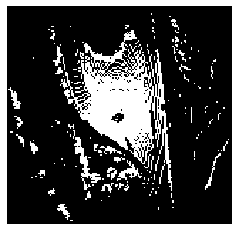

Frame 1


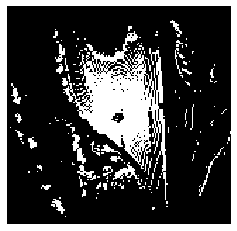

Frame 2


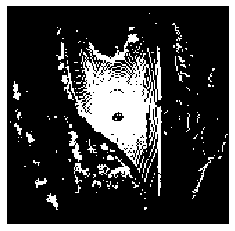

Frame 3


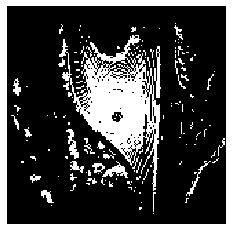

Frame 4


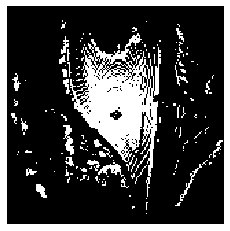

Frame 5


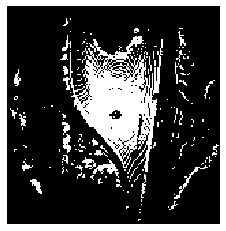

Frame 6


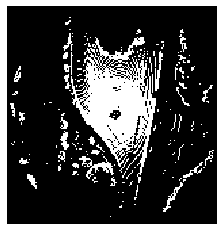

Frame 7


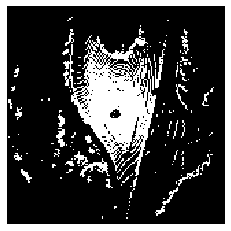

Frame 8


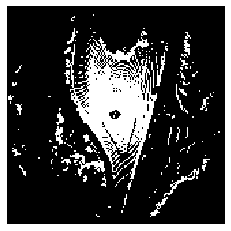

Frame 9


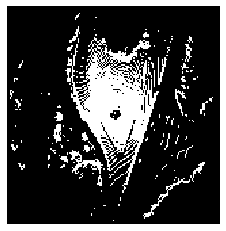

Frame 10


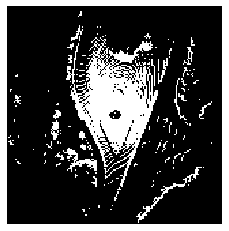

Frame 11


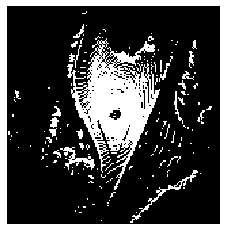

Frame 12


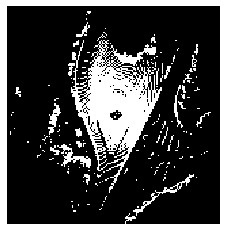

Frame 13


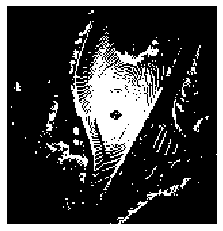

Frame 14


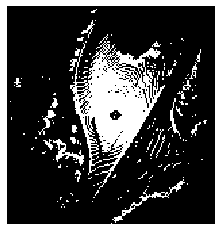

Frame 15


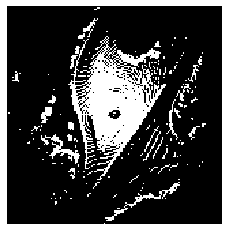

Frame 16


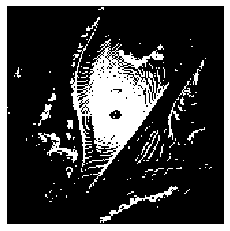

Frame 17


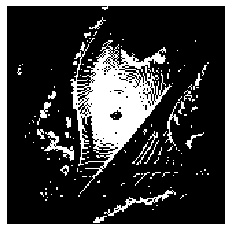

Frame 18


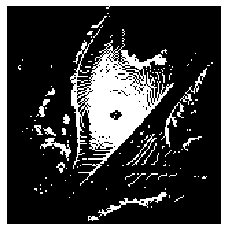

Frame 19


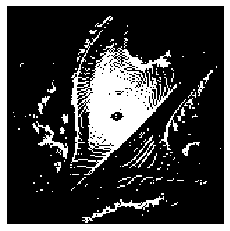

Frame 20


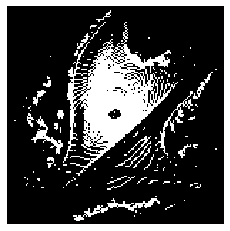

Frame 21


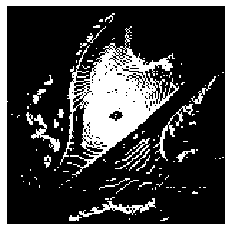

Frame 22


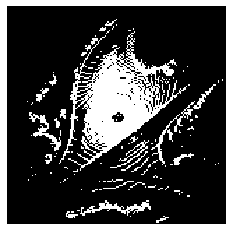

Frame 23


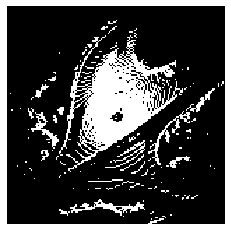

Frame 24


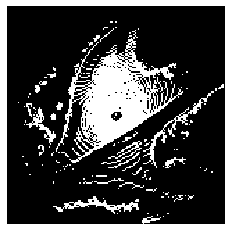

Frame 25


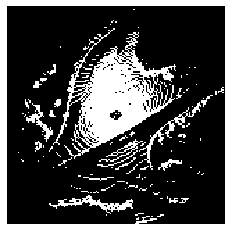

Frame 26


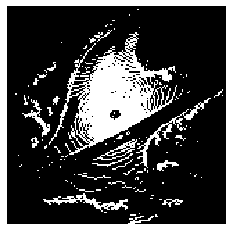

Frame 27


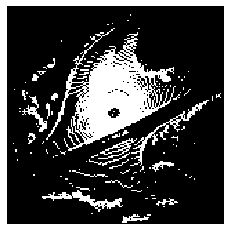

Frame 28


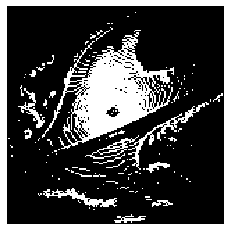

Frame 29


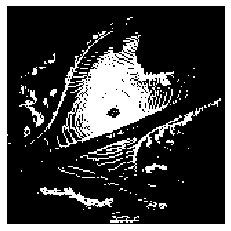

Frame 30


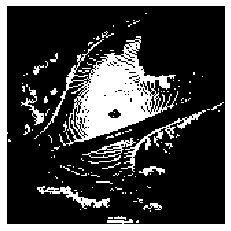

Frame 31


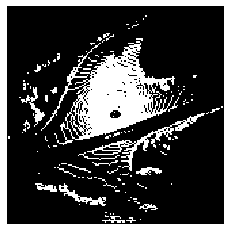

Frame 32


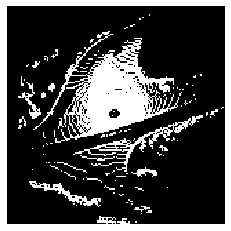

Frame 33


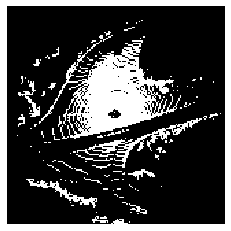

Frame 34


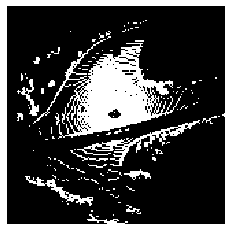

Frame 35


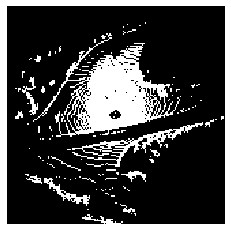

Frame 36


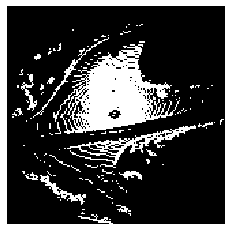

Frame 37


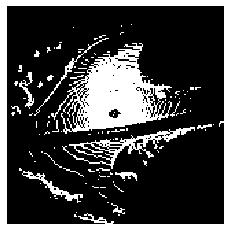

Frame 38


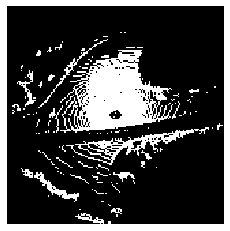

Frame 39


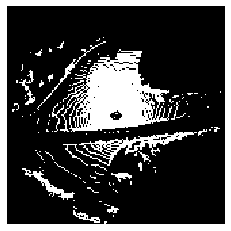

Frame 40


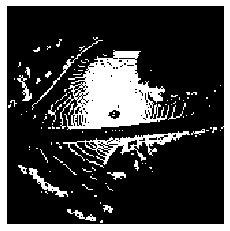

Frame 41


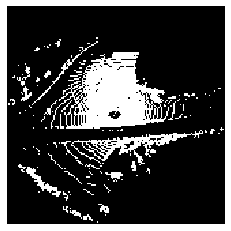

Frame 42


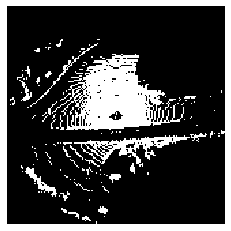

Frame 43


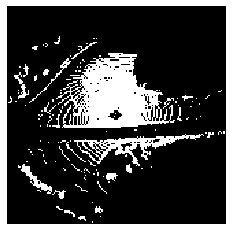

Frame 44


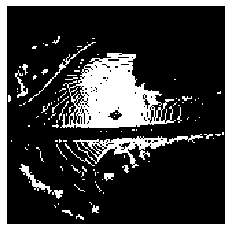

Frame 45


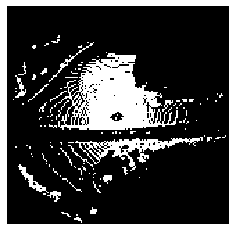

Frame 46


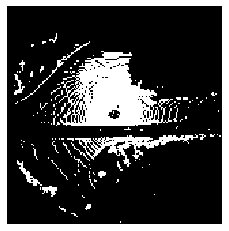

Frame 47


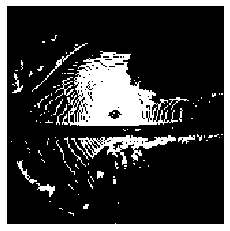

Frame 48


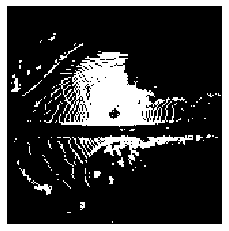

Frame 49


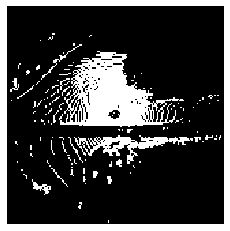

Frame 50


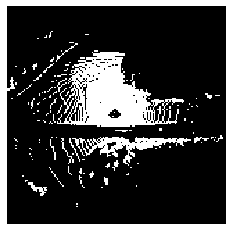

Frame 51


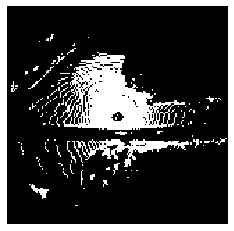

Frame 52


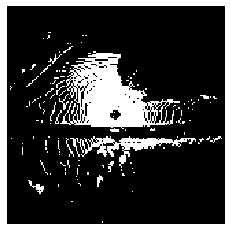

Frame 53


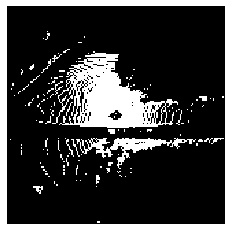

Frame 54


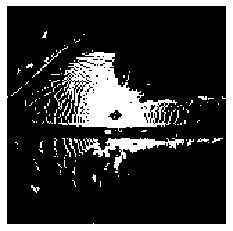

Frame 55


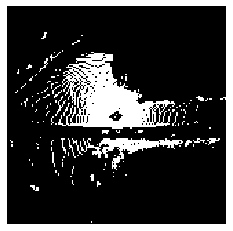

Frame 56


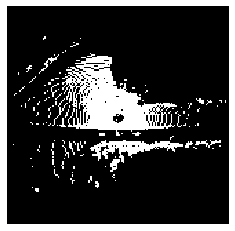

Frame 57


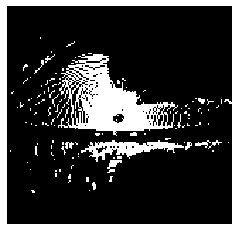

Frame 58


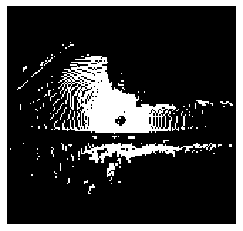

Frame 59


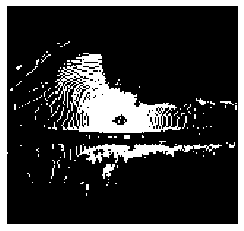

Frame 60


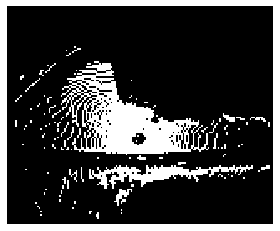

Frame 61


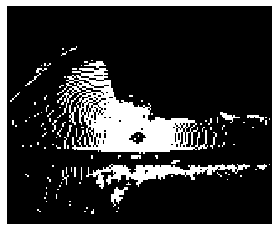

Frame 62


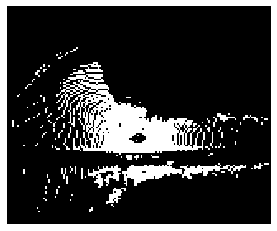

Frame 63


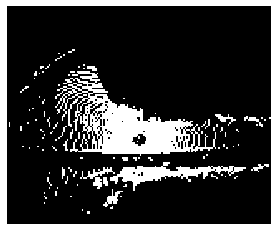

Frame 64


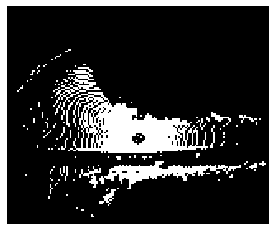

Frame 65


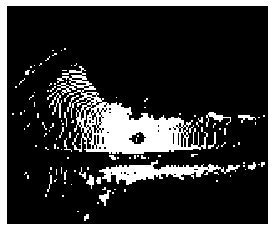

Frame 66


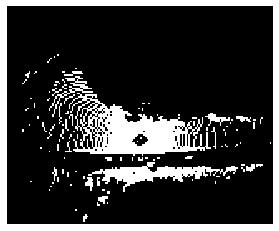

Frame 67


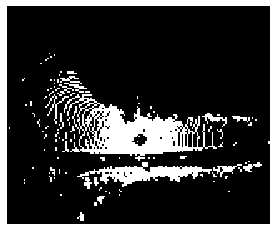

Frame 68


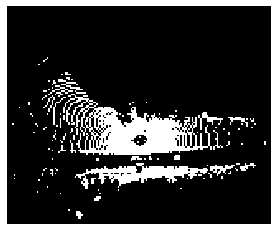

Frame 69


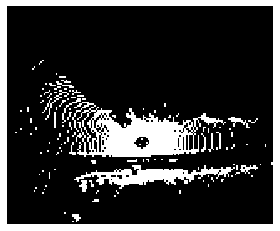

Frame 70


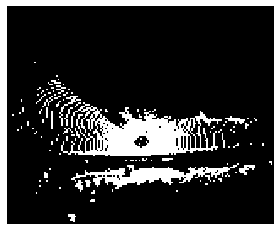

Frame 71


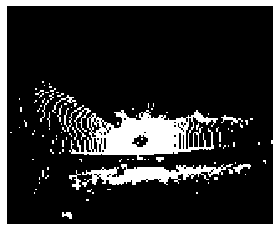

Frame 72


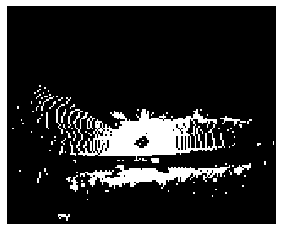

Frame 73


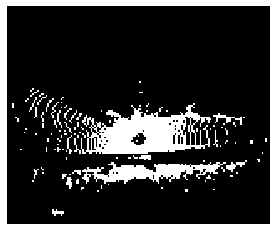

Frame 74


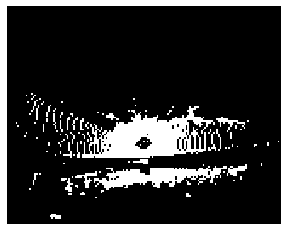

Frame 75


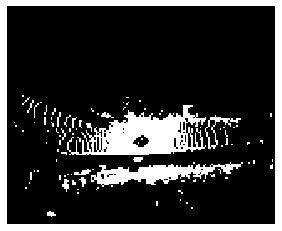

Frame 76


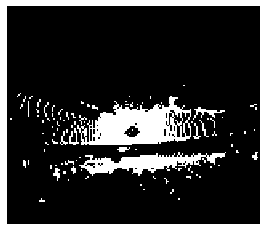

In [15]:
def genLidarOccMap():
    for frame, pcd in enumerate(framePcds):
        points = copy.deepcopy(np.asarray(pcd.points))[:, :2]
        points -= np.min(points)
        points = np.round(points).astype("int")
        
        h = np.max(points[:, 1]) + 1
        w = np.max(points[:, 0]) + 1
        
        occ = np.zeros((h, w))
        for point in points:
            occ[point[1], point[0]] += 1
        
        image = np.zeros((h, w))
        image[occ > 3] = 255
        
        print("Frame", frame)
        
        fig = plt.figure()
        plt.axis('off')
        plt.imshow(image, interpolation="none", cmap=matplotlib.colors.ListedColormap(['black', 'white']))
        plt.show()
        
        cv2.imwrite(f"results/LiDAR Occupancy/{frame}.png", image)

genLidarOccMap()

Frame 0


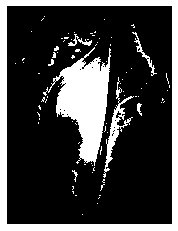

Frame 1


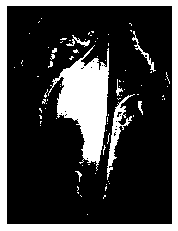

Frame 2


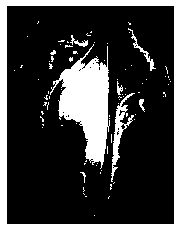

Frame 3


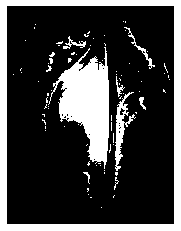

Frame 4


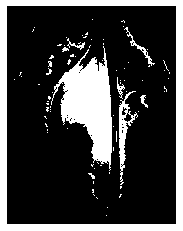

Frame 5


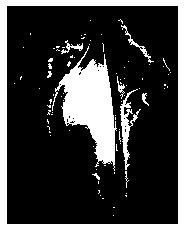

Frame 6


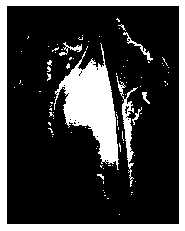

Frame 7


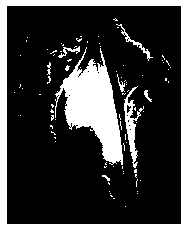

Frame 8


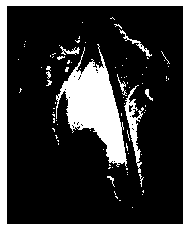

Frame 9


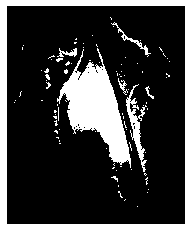

Frame 10


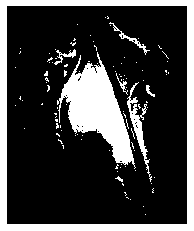

Frame 11


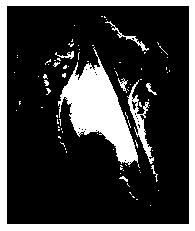

Frame 12


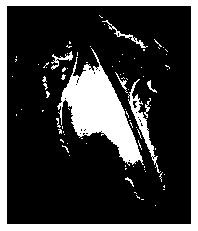

Frame 13


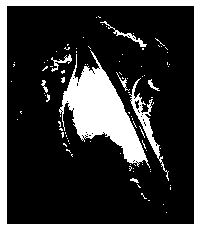

Frame 14


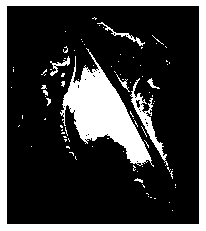

Frame 15


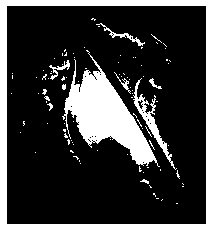

Frame 16


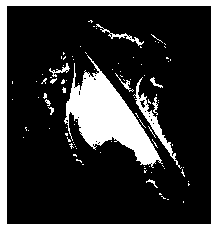

Frame 17


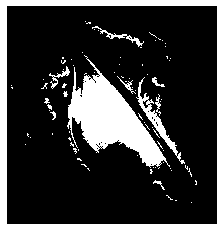

Frame 18


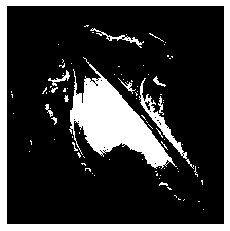

Frame 19


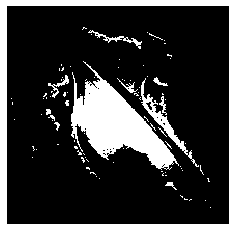

Frame 20


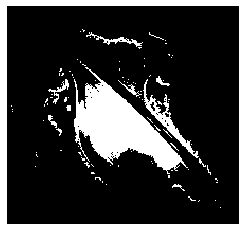

Frame 21


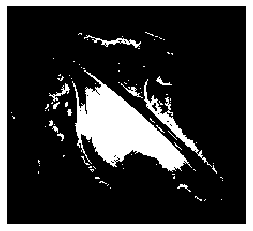

Frame 22


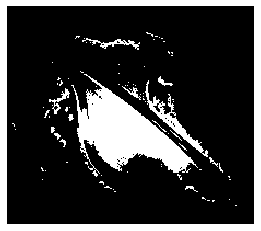

Frame 23


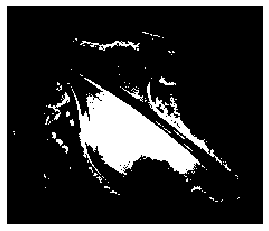

Frame 24


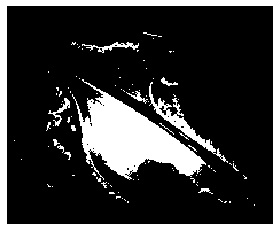

Frame 25


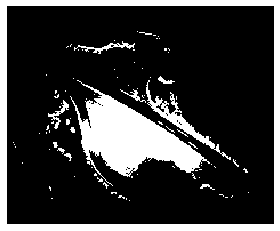

Frame 26


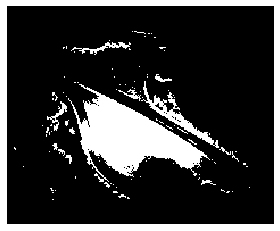

Frame 27


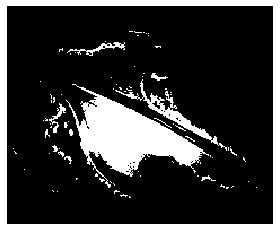

Frame 28


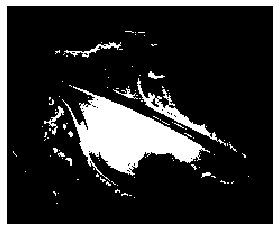

Frame 29


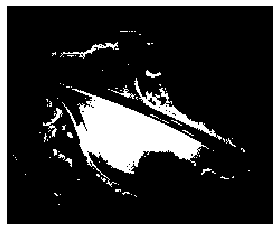

Frame 30


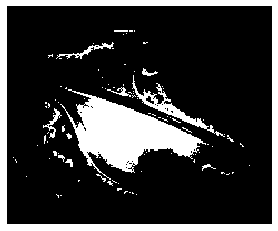

Frame 31


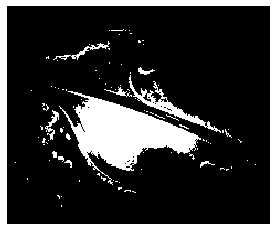

Frame 32


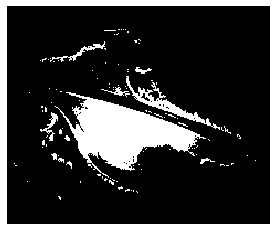

Frame 33


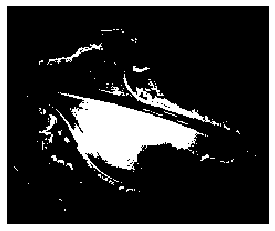

Frame 34


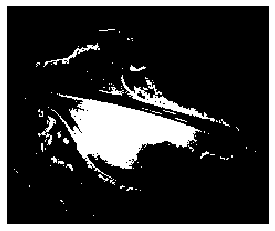

Frame 35


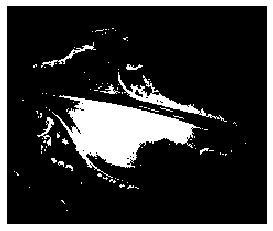

Frame 36


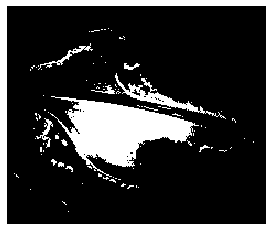

Frame 37


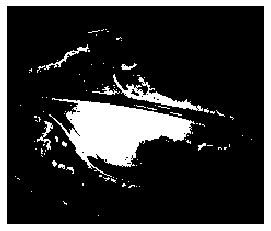

Frame 38


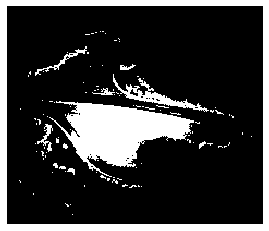

Frame 39


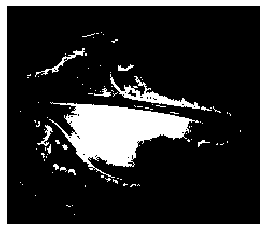

Frame 40


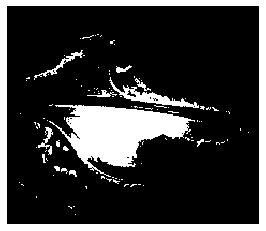

Frame 41


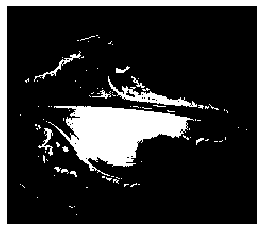

Frame 42


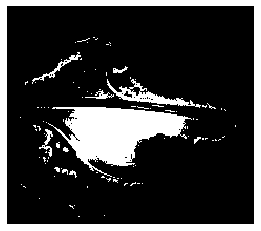

Frame 43


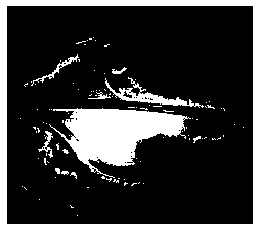

Frame 44


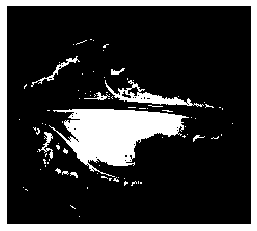

Frame 45


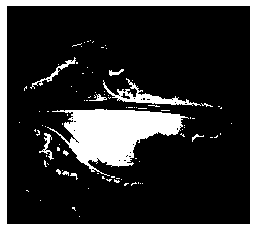

Frame 46


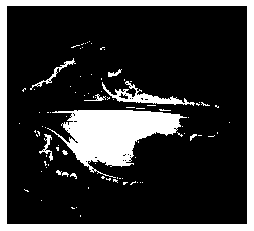

Frame 47


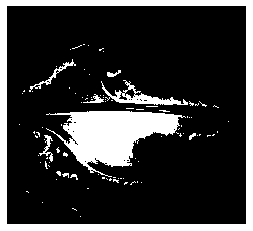

Frame 48


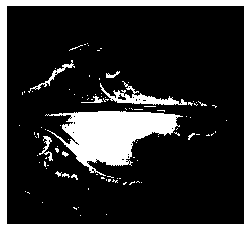

Frame 49


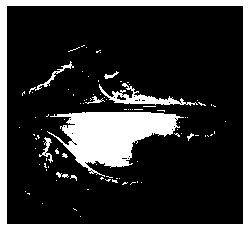

Frame 50


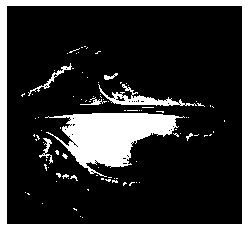

Frame 51


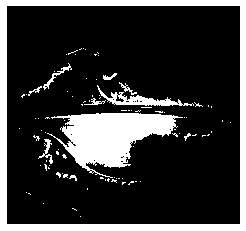

Frame 52


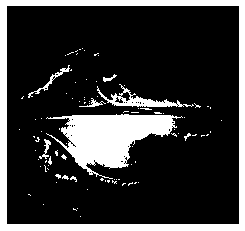

Frame 53


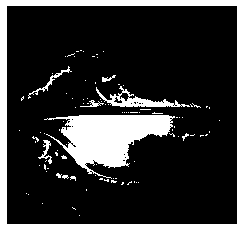

Frame 54


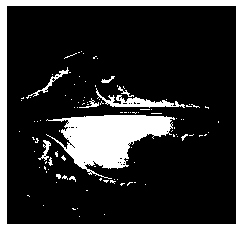

Frame 55


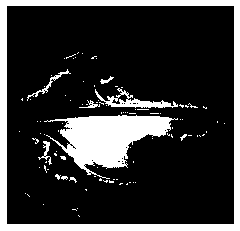

Frame 56


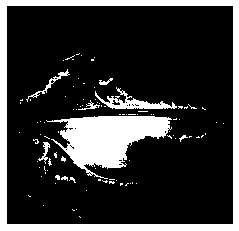

Frame 57


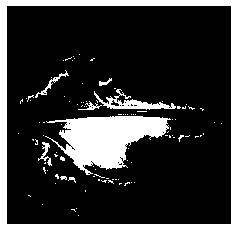

Frame 58


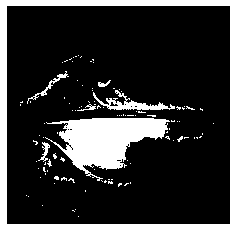

Frame 59


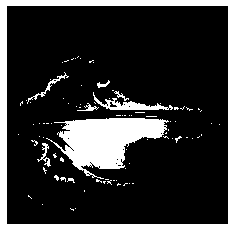

Frame 60


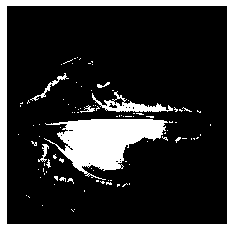

Frame 61


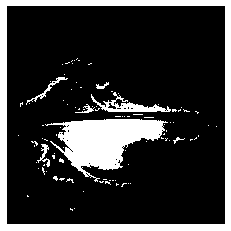

Frame 62


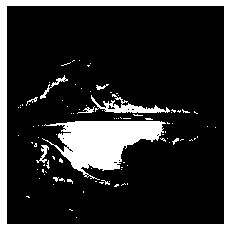

Frame 63


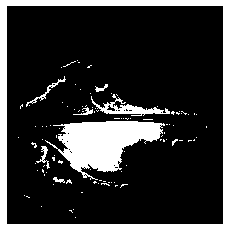

Frame 64


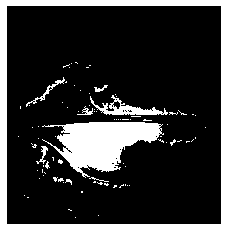

Frame 65


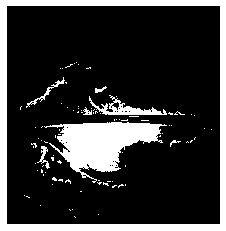

Frame 66


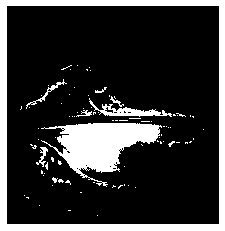

Frame 67


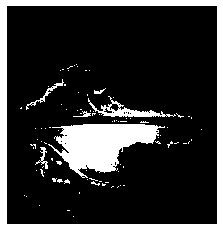

Frame 68


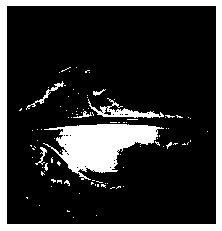

Frame 69


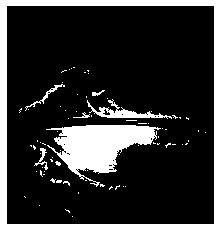

Frame 70


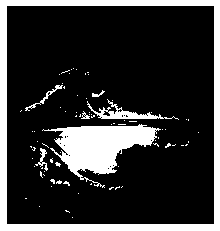

Frame 71


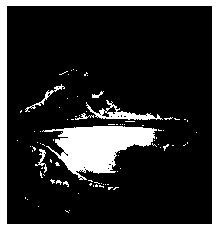

Frame 72


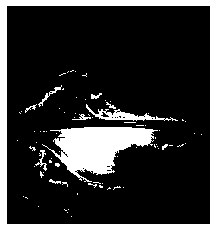

Frame 73


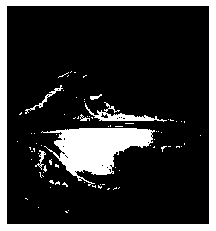

Frame 74


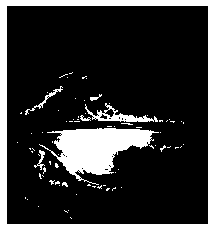

Frame 75


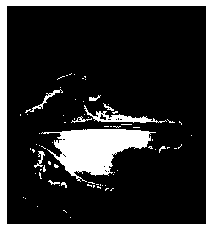

Frame 76


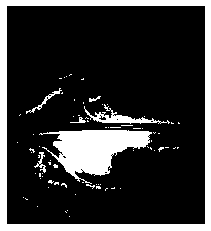

In [16]:
def genOccMap():
    for frame, pose in enumerate(homPoses):
        points = copy.deepcopy(worldPcd).transform(np.linalg.inv(pose))
        points = np.asarray(points.points)[:, :3]
        points -= np.min(points)
        points = np.round(points).astype("int")
        
        h = np.max(points[:, 0]) + 1
        w = np.max(points[:, 2]) + 1
        
        occ = np.zeros((h, w))
        for point in points:
            occ[point[0], point[2]] += 1
        
        image = np.zeros((h, w))
        image[occ > 20] = 255
        
        print("Frame", frame)
        
        fig = plt.figure()
        plt.axis('off')
        plt.imshow(image, interpolation="none", cmap=matplotlib.colors.ListedColormap(['black', 'white']))
        plt.show()
        
        cv2.imwrite(f"results/Total Occupancy/{frame}.png", image)

genOccMap()

Expected difference:
The occupancy map generated in part (2) will have more noise. This is because since we are using a combined point cloud, the probability of error is higher, resulting in more noise.

Observed difference:  
In part (1) we take the pointcloud separately for each frame. We took the threshold to be 3.   
In part (2) we take the registered pointcloud which includes all 77 frames combined. Here, we increase the threshold for a better occupancy map and to reduce noise.